In [7]:
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import copy
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)

from tqdm import tqdm
tqdm.pandas()

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')
from quantum_kernel.code.utils import compute_additional_fields
from quantum_kernel.code.kernel_measures import kernel_geometry
from quantum_kernel.code.visualization_utils import aggregate_folder
from quantum_kernel.code.utils import get_dataset


In [71]:
#Get kernel results for the different ml models and dataset.d
dfs = {}

#folders = [
#    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/plasticc/","plasticc",'Sparse_IQPm'),
#    ("/mnt/c/Users/lslat/Data/QK_project/results/RBF/plasticc/","plasticc",'rbf'),
#]

folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/rbf/plasticc/","plasticc","rbf"),
    ("/mnt/c/Users/lslat/Data/QK_project/results/laplacian/plasticc/","plasticc",'laplacian'),
]

for folder, dataset_name,kernel_name in folders:
    if dataset_name in dfs:
        temp=aggregate_folder(folder,dataset_name,kernel_name=kernel_name)[dataset_name]
        dfs[dataset_name]=pd.concat([dfs[dataset_name],temp])
    else:
        dfs[dataset_name]=aggregate_folder(folder,dataset_name,kernel_name=kernel_name)[dataset_name]
    

For /mnt/c/Users/lslat/Data/QK_project/results/rbf/plasticc/, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/rbf/plasticc/aggregated.p
For /mnt/c/Users/lslat/Data/QK_project/results/laplacian/plasticc/, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/laplacian/plasticc/aggregated.p


In [74]:
#parse the dataframes so that I have data I want.
df=dfs['plasticc']
rbf_df=df[(df['kernel_name']=='rbf') & (df['dataset_dim']==18)]
laplacian_df=df[(df['kernel_name']=='laplacian') & (df['dataset_dim']==18)]
sparse_iqpm_df=df[(df['kernel_name']=='') & (df['dataset_dim']==18)]

In [3]:
#find the best performing model idx.
best_rbf_idx=np.argmax(rbf_df['test_score'])
best_sparse_iqpm_idx=np.argmax(sparse_iqpm_df['test_score'])
#careful here. can't do the naive rbf_df['test_score'][idx] as its not a list.
print('Best rbf test score: ', rbf_df.iloc[best_rbf_idx]['test_score'])
print('Best sparse iqpm test score: ', sparse_iqpm_df.iloc[best_sparse_iqpm_idx]['test_score'])

print('Best rbf training score: ', rbf_df.iloc[best_rbf_idx]['score'])
print('Best sparse iqpm training score: ', sparse_iqpm_df.iloc[best_sparse_iqpm_idx]['score'])

NameError: name 'np' is not defined

In [63]:
#compute geometric difference between top performing models.
cK=rbf_df.iloc[best_rbf_idx]['qkern_matrix_train']
qK=sparse_iqpm_df.iloc[best_sparse_iqpm_idx]['qkern_matrix_train']
gd=kernel_geometry.geometric_difference(qK,cK,0)
gd2=kernel_geometry.geometric_difference(cK,qK,0)
print('Geometric diffence between the two models: ', gd)
print('Reversed geometirc difference: ', gd2)


print('Log scaling factor: ',sparse_iqpm_df.iloc[best_sparse_iqpm_idx]['log_scaling_factor'])
print('Log interaction scaling factor: ',sparse_iqpm_df.iloc[best_sparse_iqpm_idx]['log_int_scaling_factor'])
#Unsure how to proceed with regularization term. They only discuss lambda in the paper for one of the models. What if we have both?


Geometric diffence between the two models:  7.522434102477836
Reversed geometirc difference:  12.82896861406756
Log scaling factor:  -1.0
Log interaction scaling factor:  -2.0


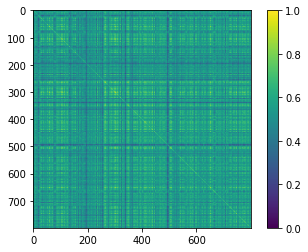

In [64]:
#does this make sense for the kernels?
plt.imshow(cK)
plt.colorbar()

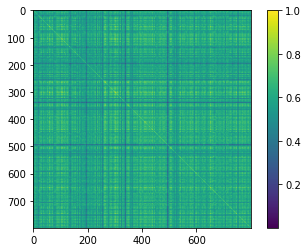

In [65]:
plt.imshow(qK)
plt.colorbar()

In [73]:
#Find the closes sparse iqpm model test score.
closest_sparse_iqpm_idx=np.argmin(np.abs(sparse_iqpm_df['test_score']-rbf_df.iloc[best_rbf_idx]['test_score']))
#careful here. can't do the naive rbf_df['test_score'][idx] as its not a list.
print('Best rbf test score: ', rbf_df.iloc[best_rbf_idx]['test_score'])
print('Closest sparse iqpm test score: ', sparse_iqpm_df.iloc[closest_sparse_iqpm_idx]['test_score'])

print('Best rbf training score: ', rbf_df.iloc[best_rbf_idx]['score'])
print('Closest sparse iqpm training score: ', sparse_iqpm_df.iloc[closest_sparse_iqpm_idx]['score'])

print('Log scaling factor: ',sparse_iqpm_df.iloc[closest_sparse_iqpm_idx]['log_scaling_factor'])
print('Log interaction scaling factor: ',sparse_iqpm_df.iloc[closest_sparse_iqpm_idx]['log_int_scaling_factor'])

Best rbf test score:  0.7339572192513368
Closest sparse iqpm test score:  0.7341800356506238
Best rbf training score:  0.735
Closest sparse iqpm training score:  0.765
Log scaling factor:  -0.8
Log interaction scaling factor:  -1.0


In [67]:
#compute geometric difference between top performing rbf model 
cK=rbf_df.iloc[best_rbf_idx]['qkern_matrix_train']
qK=sparse_iqpm_df.iloc[closest_sparse_iqpm_idx]['qkern_matrix_train']
gd=kernel_geometry.geometric_difference(qK,cK,0)
gd2=kernel_geometry.geometric_difference(cK,qK,0)
print('Geometric diffence between the two models: ', gd)
print('Reversed geometirc difference: ', gd2)

Geometric diffence between the two models:  30.94441335793664
Reversed geometirc difference:  8.028892162372621


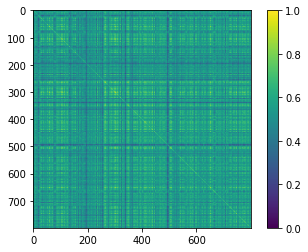

In [68]:
#does this make sense for the kernels?
plt.imshow(cK)
plt.colorbar()

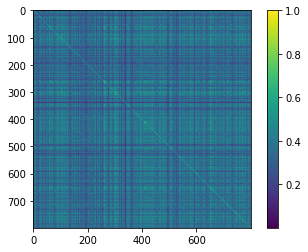

In [69]:
plt.imshow(qK)
plt.colorbar()

In [76]:
#find the best performing model idx.
best_rbf_idx=np.argmax(rbf_df['test_score'])
best_laplacian_idx=np.argmax(laplacian_df['test_score'])
#careful here. can't do the naive rbf_df['test_score'][idx] as its not a list.
print('Best rbf test score: ', rbf_df.iloc[best_rbf_idx]['test_score'])
print('Best laplacian test score: ', laplacian_df.iloc[best_laplacian_idx]['test_score'])

print('Best rbf training score: ', rbf_df.iloc[best_rbf_idx]['score'])
print('Best laplacian training score: ', laplacian_df.iloc[best_laplacian_idx]['score'])

Best rbf test score:  0.7339572192513368
Best laplacian test score:  0.7381907308377897
Best rbf training score:  0.735
Best laplacian training score:  0.72


In [82]:
#compute geometric difference between top performing rbf model 
cKr=rbf_df.iloc[best_rbf_idx]['qkern_matrix_train']
cKl=laplacian_df.iloc[best_laplacian_idx]['qkern_matrix_train']
gd=kernel_geometry.geometric_difference(cKr,cKl,0)
gd2=kernel_geometry.geometric_difference(cKl,cKr,0)
print('Geometric diffence between the two models: ', gd)
print('Reversed geometirc difference: ', gd2)

Geometric diffence between the two models:  8.782227911827066
Reversed geometirc difference:  103.4365993029054


Examining Geometric Difference as a function of hyperparameter

In [91]:
a=rbf_df['qkern_matrix_train']

In [96]:
rbf_df

,qkern_matrix_train,qkern_matrix_test,score,args,K_train_time,K_test_time,outpath,dataset_dim,kernel,gamma,decimals,dataset,test_score,train_score,n_support,n_support_ave,C,norm(qkern_matrix_train - identity),kernel_name,Number of qubits
0,"[[1.0, 0.9050727351920593, 0.9588061297210496,...","[[0.9874176592323252, 0.906069186486184, 0.954...",0.660,Namespace(outpath=PosixPath('/mnt/c/Users/lsla...,0.076732,0.009438,/mnt/c/Users/lslat/Data/QK_project/results/rbf...,18,rbf,0.0010,None,plasticc,0.664439,0.753955,"[224, 249]",236.5,256.000,746.725247,rbf,19
1,"[[1.0, 0.7793228159993315, 0.9000255827220011,...","[[0.9688208884034509, 0.781426641054927, 0.891...",0.680,Namespace(outpath=PosixPath('/mnt/c/Users/lsla...,0.055011,0.007165,/mnt/c/Users/lslat/Data/QK_project/results/rbf...,18,rbf,0.0025,None,plasticc,0.716132,0.771446,"[220, 250]",235.0,64.000,680.476343,rbf,19
2,"[[1.0, 0.8192265691903716, 0.9193062975479448,...","[[0.9749804033244628, 0.8209304781724642, 0.91...",0.660,Namespace(outpath=PosixPath('/mnt/c/Users/lsla...,0.056678,0.007140,/mnt/c/Users/lslat/Data/QK_project/results/rbf...,18,rbf,0.0020,None,plasticc,0.664661,0.754902,"[228, 251]",239.5,64.000,701.352858,rbf,19
3,"[[1.0, 0.7053605503565683, 0.8630583808730684,...","[[0.9567803737632761, 0.7079476574150885, 0.85...",0.685,Namespace(outpath=PosixPath('/mnt/c/Users/lsla...,0.058086,0.007312,/mnt/c/Users/lslat/Data/QK_project/results/rbf...,18,rbf,0.0035,None,plasticc,0.705214,0.769608,"[225, 254]",239.5,32.000,641.877917,rbf,19
4,"[[1.0, 0.6710482791411302, 0.8451777669817785,...","[[0.9506848845850155, 0.6740083068964535, 0.83...",0.695,Namespace(outpath=PosixPath('/mnt/c/Users/lsla...,0.059205,0.006785,/mnt/c/Users/lslat/Data/QK_project/results/rbf...,18,rbf,0.0040,None,plasticc,0.711453,0.848708,"[197, 227]",212.0,128.000,624.007126,rbf,19
5,"[[1.0, 0.6073961474903862, 0.8103093021919424,...","[[0.9386917982202301, 0.6106419724880441, 0.79...",0.705,Namespace(outpath=PosixPath('/mnt/c/Users/lsla...,0.057961,0.007104,/mnt/c/Users/lslat/Data/QK_project/results/rbf...,18,rbf,0.0050,None,plasticc,0.705214,0.765931,"[226, 254]",240.0,16.000,590.813135,rbf,19
6,"[[1.0, 0.3689805459181406, 0.6568525844242387,...","[[0.8807466310237356, 0.37286339327528567, 0.6...",0.735,Namespace(outpath=PosixPath('/mnt/c/Users/lsla...,0.055436,0.007236,/mnt/c/Users/lslat/Data/QK_project/results/rbf...,18,rbf,0.0100,None,plasticc,0.733957,0.831272,"[210, 245]",227.5,16.000,463.686522,rbf,19
7,"[[1.0, 0.05024349624406461, 0.283030269565378,...","[[0.6842564306144433, 0.051793675237891225, 0....",0.770,Namespace(outpath=PosixPath('/mnt/c/Users/lsla...,0.056485,0.007065,/mnt/c/Users/lslat/Data/QK_project/results/rbf...,18,rbf,0.0300,None,plasticc,0.708779,0.829490,"[233, 279]",256.0,2.000,239.744873,rbf,19
8,"[[1.0, 4.662358202376163e-05, 0.01493304913474...","[[0.28185542720877926, 5.198693404948702e-05, ...",0.780,Namespace(outpath=PosixPath('/mnt/c/Users/lsla...,0.055718,0.006730,/mnt/c/Users/lslat/Data/QK_project/results/rbf...,18,rbf,0.1000,None,plasticc,0.704545,0.945633,"[252, 359]",305.5,2.000,72.041555,rbf,19
9,"[[1.0, 1.0113175900006874e-13, 3.3056173412096...","[[0.022248811539110427, 1.4067554892786853e-13...",0.730,Namespace(outpath=PosixPath('/mnt/c/Users/lsla...,0.065260,0.007660,/mnt/c/Users/lslat/Data/QK_project/results/rbf...,18,rbf,0.3000,None,plasticc,0.646390,1.000000,"[271, 502]",386.5,2.000,16.066335,rbf,19
